In [93]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from NetworkModel import *
from Round import *

### Modelos e Parâmetros

In [94]:
# Modelo de Rede Neural
class ModelMLP:
    @staticmethod
    def create_model():
        model = tf.keras.models.Sequential(
            [
                tf.keras.layers.Dense(units=128, activation='relu', input_shape=(784,)),
                tf.keras.layers.Dense(10, activation="softmax")
            ]
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
        )
        return model

In [95]:
# Definição dos parâmetros
NUMBER_OF_ROUNDS = 100
TOTAL_CLIENTS = 100
CLIENTS_PER_ROUND = 10
EPSILON_DELTA = 40
NUMBER_OF_TESTS = 5
SAVE_FIGURES = True

### Cliente

In [96]:
class Client():
    def __init__(self, cid):
        self.cid = int(cid)
        self.model = ModelMLP.create_model()
        self.old_weights = None
        (self.x_train, self.y_train), (self.x_test, self.y_test) = self.load_data()


    def load_data(self):
        path = "../dataset-mnist/non-iid-0.9-100-rotation-45"

        train = pd.read_pickle(f"{path}/{self.cid+1}_train.pickle")
        test = pd.read_pickle(f"{path}/{self.cid+1}_test.pickle")

        x_train = train.drop(['label'], axis=1)
        y_train = train['label']

        x_test = test.drop(['label'], axis=1)
        y_test = test['label']

        return (x_train, y_train), (x_test, y_test)


    def fit(self, parameters, config=None):
        self.model.set_weights(parameters)
        history = self.model.fit(self.x_train, self.y_train, epochs=5, batch_size=128,
                                 validation_data=(self.x_test, self.y_test), verbose=False)
        self.current_weights = self.model.get_weights()
        sample_size = len(self.x_train)
        print(f"Acurácia: {history.history['val_accuracy'][-1]} | ", end='')
        if self.old_weights is not None:
            weight_diff = np.mean([
                np.mean(np.abs((w1 - w2) / w2) * 100) 
                for w1, w2 in zip(self.current_weights, self.old_weights)
                if np.sum(np.abs(w2)) > 0  # Evitar divisão por zero
            ])
            print(f"Diferença dos pesos: {weight_diff}")
            self.old_weights = self.current_weights
            if weight_diff < EPSILON_DELTA:
                print("weight_diff < EPSILON_DELTA. O modelo não será transmitido.")
                return None
            else:
                print("ENVIADO!")
                return self.current_weights, sample_size, {"val_accuracy": history.history['val_accuracy'][-1],
                                                               "val_loss": history.history['val_loss'][-1]}
        else:
            print("ENVIANDO PRIMEIRA")
            self.old_weights = self.current_weights
            return self.current_weights, sample_size, {"val_accuracy": history.history['val_accuracy'][-1],
                                                               "val_loss": history.history['val_loss'][-1]}


    def evaluate(self, parameters):
        self.model.set_weights(parameters)
        return self.model.evaluate(self.x_test, self.y_test, verbose=False)

### Servidor

In [97]:
class Server():
    def __init__(self, n_rounds, total_number_clients, min_fit_clients):
        self.n_rounds = n_rounds
        self.total_number_clients = total_number_clients
        self.min_fit_clients = min_fit_clients

        self.server_round = 0
        self.selected_clients = []
        self.model = ModelMLP.create_model()
        self.w_global = self.model.get_weights()

        self.clients_model_list = []
        # Vamos guardar todos os modelos (pesos) anteriores, mas não é necessário
        self.clients_previous_models_list = [ [] for _ in range(total_number_clients) ]
        self.create_models()
        (self.x_train, self.y_train), (self.x_test, self.y_test) = self.load_data()


    def load_data(self):
        path = "../dataset-mnist/mnist"

        train = pd.read_pickle(f"{path}/train.pickle")
        test = pd.read_pickle(f"{path}/test.pickle")

        x_train = train.drop(['label'], axis=1)
        y_train = train['label']

        # test = pd.concat([test, train])
        x_test = test.drop(['label'], axis=1)
        y_test = test['label']

        return (x_train, y_train), (x_test, y_test)


    def create_models(self):
        for i in range(self.total_number_clients):
            self.clients_model_list.append(Client(i))


    def aggregate_fit(self, weight_list, sample_sizes):
        self.w_global = []
        for weights in zip(*weight_list):
            weighted_sum = 0
            total_samples = sum(sample_sizes)
            for i in range(len(weights)):
                weighted_sum += weights[i] * sample_sizes[i]
            self.w_global.append(weighted_sum / total_samples)


    def configure_fit(self, selected_clients = None):
        if selected_clients is None:
            self.selected_clients = np.random.permutation(list(range(self.total_number_clients)))[:self.min_fit_clients]
        else:
            self.selected_clients = selected_clients
        print(f"Clientes selecionados: \033[34;1m{np.array(self.selected_clients) + 1}\033[37;0m")

    
    def get_client_previous_model(self, client_id):
        return self.clients_previous_models_list[client_id][-1]


    def save_client_previous_model(self, client_id, model):
        self.clients_previous_models_list[client_id].append(model)


    def fit(self):
        weight_list, sample_sizes_list, info_list, sender_clients = [], [], [], []
        for i, pos in enumerate(self.selected_clients):
            print(f"Cliente #{pos+1} | ", end='')

            # Se o cliente decidir não enviar o modelo, ele retorna um None
            new_model = self.clients_model_list[pos].fit(parameters=self.w_global)

            weights, size, info = new_model if new_model is not None else self.get_client_previous_model(pos)
            weight_list.append(weights)
            sample_sizes_list.append(size)
            info_list.append(info)

            # Se o cliente enviou um novo modelo, salve-o e insira-o ao sender_client
            if new_model is not None:
                self.save_client_previous_model(pos, (weights, size, info_list))
                sender_clients.append(pos)

        return weight_list, sample_sizes_list, {"acc_loss_local":[(pos+1, info_list[i]) for i, pos in enumerate(self.selected_clients)]}, sender_clients


    def distributed_evaluation(self):
        loss_list, accuracy_list = [], []
        for i in range(self.total_number_clients):
            loss, accuracy = self.clients_model_list[i].evaluate(parameters=self.w_global)
            # print(f"Evaluate - CID: {i+1} - accuracy: {accuracy}")
            loss_list.append(loss)
            accuracy_list.append(accuracy)
        return sum(loss_list) / len(loss_list), sum(accuracy_list) / len(accuracy_list), {"accuracy_list": [(i+1, accuracy) for i, accuracy in enumerate(accuracy_list)]}


    def centralized_evaluation(self):
        self.model.set_weights(self.w_global)
        return self.model.evaluate(self.x_test, self.y_test, verbose=False)

### Execução e Exibição

In [98]:
network_model = NetworkModel()

def executar(id):
    print('\n' + '='*40)
    print("{:^54}".format('\033[;1m' + 'CARREGAMENTO DE DADOS' + '\033[37;0m'))
    print("{:^40}".format(f'Número total de clientes: {TOTAL_CLIENTS}' + '\n'))
    
    s = Server(n_rounds=NUMBER_OF_ROUNDS,
               total_number_clients=TOTAL_CLIENTS,
               min_fit_clients=CLIENTS_PER_ROUND)
    
    print('\n' + '='*40)
    print("{:^54}".format('\033[;1m' + 'INICIANDO' + '\033[37;0m'))
    print("{:^40}".format(f'Clientes por rodada: {CLIENTS_PER_ROUND} ' + '\n'))
    
    evaluate_list = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}
    network_model = NetworkModel(usernumber=TOTAL_CLIENTS, RBnumber=CLIENTS_PER_ROUND)
    transmissions_per_round = []
    energy_consumption_per_round = []
    
    # Rodadas de comunicação
    for s.server_round in range(s.n_rounds):
        communication_round = Round(network_model)
        
        print('\033[;1m' + f'Rodada {s.server_round+1}/{s.n_rounds}' + '\033[37;0m')
    
        # Seleciona os clientes que participarão da próxima rodada de comunicação
        _, selected_clients = network_model.selecao_clientes_aleatoria()
        q, rbs_attribution = network_model.atribuicao_RBs(selected_clients)
        print(rbs_attribution)

        
        s.configure_fit(selected_clients)
        
        # Treinamento local do dispositivo
        weight_list, sample_sizes, info, sender_clients = s.fit()
        communication_round.set_clients(selected_clients)
        communication_round.set_sender_clients(sender_clients)
        communication_round.set_rb_allocation(rbs_attribution)
    
        # Salva a quantidade de transmissões ocorridas nesta rodada
        transmissions_count = len(sender_clients)
        transmissions_per_round.append(transmissions_count)

        round_total_energy_consumption = communication_round.get_round_final_energy()
        energy_consumption_per_round.append(round_total_energy_consumption)
        
        # Agregação
        s.aggregate_fit(weight_list, sample_sizes)
    
        # Avaliação centralizada
        print('\033[3;1m' + '-'*40 + '\033[37;0m')
        # print(f"Avaliação centralizada")
        evaluate_loss, evaluate_accuracy = s.centralized_evaluation()
        print(f"Execução #{id}")
        print(f"Transmissões nesta rodada: {transmissions_count}")
        print(f"Acurácia: {evaluate_accuracy}")
        evaluate_list["centralized"]["loss"].append(evaluate_loss)
        evaluate_list["centralized"]["accuracy"].append(evaluate_accuracy)
        print(f"Energia total da rodada: {round_total_energy_consumption}")
        print('\033[3;1m' + '-'*40 + '\033[37;0m' + '\n')
    
    print('\n\n' + '='*40)
    print("{:^54}".format('\033[;1m' + 'RESULTADOS FINAIS' + '\033[37;0m'))
    print(f"\nCentralized loss: ", end='')
    print(evaluate_list["centralized"]["loss"])
    print(f"Centralized accuracy: ", end='')
    print(evaluate_list["centralized"]["accuracy"])

    return evaluate_list["centralized"]["accuracy"], evaluate_list["centralized"]["loss"], transmissions_per_round, energy_consumption_per_round 

In [99]:
def plotar_grafico_acuracia(save_figure=True, path=""):
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Acurácia', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(acc_list[0]))], [np.mean(p) for p in zip(*acc_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#00aaff', linewidth = 1)
    y_min = [np.min(p) for p in zip(*acc_list)]
    y_max = [np.max(p) for p in zip(*acc_list)]
    ax.fill_between(x1, y_min, y_max, color='#00aaff', alpha=0.1)
    if save_figure:
        plt.savefig(f"{path}acuracia_transmissao_total.jpg", dpi=2400, bbox_inches='tight')

In [100]:
def plotar_grafico_perda(save_figure=True, path=""):
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Perda', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(loss_list[0]))], [np.mean(p) for p in zip(*loss_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#ff0000', linewidth = 1)
    y_min = [np.min(p) for p in zip(*loss_list)]
    y_max = [np.max(p) for p in zip(*loss_list)]
    ax.fill_between(x1, y_min, y_max, color='#ff0000', alpha=0.1)
    if save_figure:
        plt.savefig(f"{path}loss_transmissao_total.jpg", dpi=2400, bbox_inches='tight')

In [101]:
def plotar_grafico_transmissoes(save_figure=True, path=""):
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Transmissões', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(transmissions_list[0]))], [np.mean(p) for p in zip(*transmissions_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#44aa44', linewidth = 1)
    y_min = [np.min(p) for p in zip(*transmissions_list)]
    y_max = [np.max(p) for p in zip(*transmissions_list)]
    ax.fill_between(x1, y_min, y_max, color='#44aa44', alpha=0.1)
    if save_figure:
        plt.savefig(f"{path}transmissoes_transmissao_total.jpg", dpi=2400, bbox_inches='tight')

In [102]:
def plotar_grafico_transmissoes_acumuladas(save_figure=True, path=""):
    acc_transmissions_list = [
        [np.sum(transmission_list[0:i]) for i in range(len(transmission_list))] 
        for transmission_list in transmissions_list
    ]
    
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Transmissões Acumuladas', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(acc_transmissions_list[0]))], [np.mean(p) for p in zip(*acc_transmissions_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#ffa500', linewidth = 1)
    y_min = [np.min(p) for p in zip(*acc_transmissions_list)]
    y_max = [np.max(p) for p in zip(*acc_transmissions_list)]
    ax.fill_between(x1, y_min, y_max, color='#ffa500', alpha=0.1)
    if save_figure:
        plt.savefig(f"{path}transmissoes_acumuladas_transmissao_total.jpg", dpi=2400, bbox_inches='tight')

In [103]:
def plotar_grafico_energia(save_figure=True, path=""):
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Energia', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(energy_consumption_list[0]))], [np.mean(p) for p in zip(*energy_consumption_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#C433FF', linewidth = 1)
    y_min = [np.min(p) for p in zip(*energy_consumption_list)]
    y_max = [np.max(p) for p in zip(*energy_consumption_list)]
    ax.fill_between(x1, y_min, y_max, color='#C433FF', alpha=0.1)
    if save_figure:
        plt.savefig(f"{path}energia_transmissao_total.jpg", dpi=2400, bbox_inches='tight')

In [104]:
def plotar_grafico_energia_acumulada(save_figure=True, path=""):
    acc_energy_list = [
        [np.sum(energy_consumption_list[0:i]) for i in range(len(energy_consumption_list))] 
        for energy_consumption_list in energy_consumption_list
    ]
    
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Energia Acumulada', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(acc_energy_list[0]))], [np.mean(p) for p in zip(*acc_energy_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#EA5FCB', linewidth = 1)
    y_min = [np.min(p) for p in zip(*acc_energy_list)]
    y_max = [np.max(p) for p in zip(*acc_energy_list)]
    ax.fill_between(x1, y_min, y_max, color='#EA5FCB', alpha=0.1)
    if save_figure:
        plt.savefig(f"{path}energia_acumulada_transmissao_total.jpg", dpi=2400, bbox_inches='tight')

In [105]:
def plotar_graficos(save_figure=True, path=""):
    plotar_grafico_acuracia(save_figure, path)
    plotar_grafico_perda(save_figure, path)
    plotar_grafico_transmissoes(save_figure, path)
    plotar_grafico_transmissoes_acumuladas(save_figure, path)
    plotar_grafico_energia(save_figure, path)
    plotar_grafico_energia_acumulada(save_figure, path)

### Exemplo 1 - Epsilon = 40

In [106]:
acc_list, loss_list, transmissions_list, energy_consumption_list = [], [], [], []

for i in range(NUMBER_OF_TESTS):
    acc, loss, transmissions, energy_consumption  = executar(i)
    acc_list.append(acc)
    loss_list.append(loss)
    transmissions_list.append(transmissions)
    energy_consumption_list.append(energy_consumption)


          CARREGAMENTO DE DADOS           
      Número total de clientes: 2
      

                INICIANDO                 
        Clientes por rodada: 1 
        
Rodada 1/2
[1]
Clientes selecionados: [2]
Cliente #2 | Acurácia: 0.926369845867157 | ENVIANDO PRIMEIRA
0: -> Disp: 1, RB: 0: 0.0007379595707139726
----------------------------------------
Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.48820000886917114
Energia total da rodada: 0.0007379595707139726
----------------------------------------

Rodada 2/2
[1]
Clientes selecionados: [2]
Cliente #2 | Acurácia: 0.9383561611175537 | Diferença dos pesos: 15.746270179748535
weight_diff < EPSILON_DELTA. O modelo não será transmitido.
0: -> Disp: 1, RB: 0: 0.0007379595707139726
----------------------------------------
Execução #0
Transmissões nesta rodada: 0
Acurácia: 0.48820000886917114
Energia total da rodada: 1.552886962890625e-08
----------------------------------------



            RESULTADOS FINAIS             

Centr

In [107]:
energy_consumption_list

[[0.0007379595707139726, 1.552886962890625e-08]]

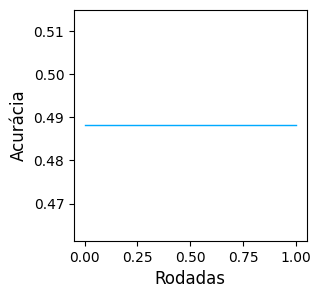

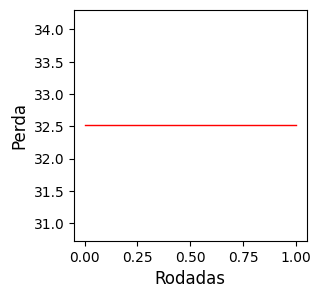

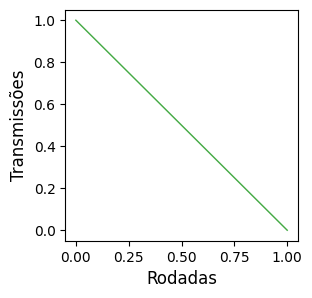

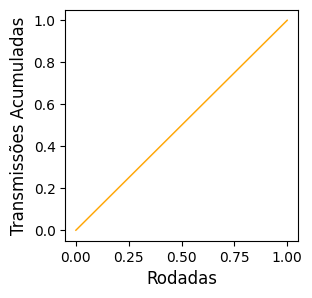

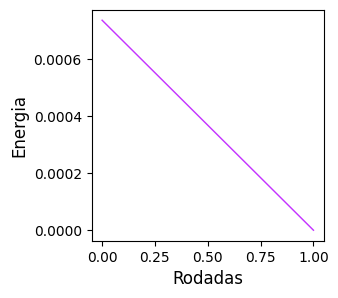

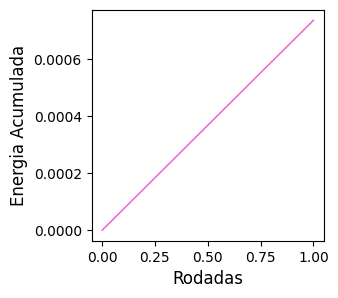

In [108]:
plotar_graficos(save_figure=SAVE_FIGURES, path="graficos/transmissao_condicional/epsilon_40/")

### Exemplo 2 - Epsilon = 25

In [109]:
EPSILON_DELTA = 25

In [110]:
acc_list, loss_list, transmissions_list, energy_consumption_list = [], [], [], []

for i in range(NUMBER_OF_TESTS):
    acc, loss, transmissions, energy_consumption  = executar(i)
    acc_list.append(acc)
    loss_list.append(loss)
    transmissions_list.append(transmissions)
    energy_consumption_list.append(energy_consumption)


          CARREGAMENTO DE DADOS           
      Número total de clientes: 2
      

                INICIANDO                 
        Clientes por rodada: 1 
        
Rodada 1/2
[0]
Clientes selecionados: [1]
Cliente #1 | Acurácia: 0.9332405924797058 | ENVIANDO PRIMEIRA
0: -> Disp: 0, RB: 0: 0.001447206387061676
----------------------------------------
Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.531499981880188
Energia total da rodada: 0.001447206387061676
----------------------------------------

Rodada 2/2
[0]
Clientes selecionados: [1]
Cliente #1 | Acurácia: 0.9360222816467285 | Diferença dos pesos: 23.64920425415039
weight_diff < EPSILON_DELTA. O modelo não será transmitido.
0: -> Disp: 0, RB: 0: 0.001447206387061676
----------------------------------------
Execução #0
Transmissões nesta rodada: 0
Acurácia: 0.531499981880188
Energia total da rodada: 1.552886962890625e-08
----------------------------------------



            RESULTADOS FINAIS             

Centralized 

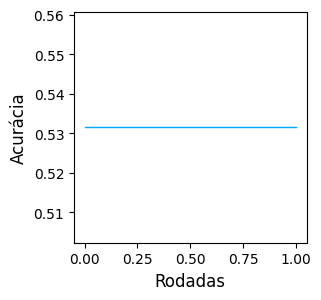

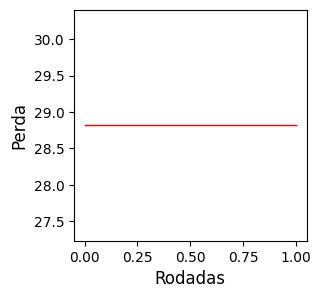

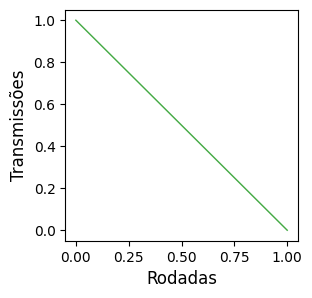

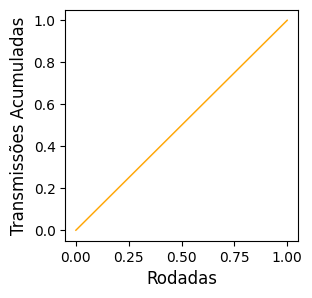

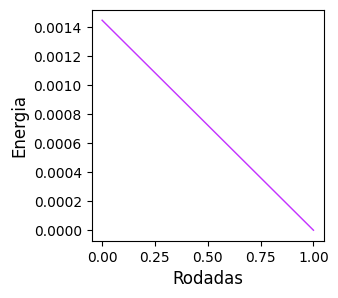

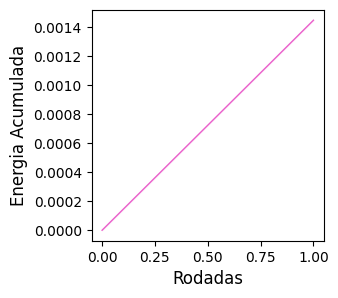

In [111]:
plotar_graficos(save_figure=SAVE_FIGURES, path="graficos/transmissao_condicional/epsilon_25/")

### Exemplo 3 - Epsilon = 55

In [112]:
EPSILON_DELTA = 55

In [113]:
acc_list, loss_list, transmissions_list, energy_consumption_list = [], [], [], []

for i in range(NUMBER_OF_TESTS):
    acc, loss, transmissions, energy_consumption  = executar(i)
    acc_list.append(acc)
    loss_list.append(loss)
    transmissions_list.append(transmissions)
    energy_consumption_list.append(energy_consumption)


          CARREGAMENTO DE DADOS           
      Número total de clientes: 2
      

                INICIANDO                 
        Clientes por rodada: 1 
        
Rodada 1/2
[1]
Clientes selecionados: [2]
Cliente #2 | Acurácia: 0.931506872177124 | ENVIANDO PRIMEIRA
0: -> Disp: 1, RB: 0: 0.0008495084294425582
----------------------------------------
Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.4609000086784363
Energia total da rodada: 0.0008495084294425582
----------------------------------------

Rodada 2/2
[0]
Clientes selecionados: [1]
Cliente #1 | Acurácia: 0.9457579851150513 | ENVIANDO PRIMEIRA
0: -> Disp: 0, RB: 0: 0.0011131839995647624
----------------------------------------
Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.6064000129699707
Energia total da rodada: 0.0011131839995647624
----------------------------------------



            RESULTADOS FINAIS             

Centralized loss: [30.33662986755371, 17.119482040405273]
Centralized accuracy: [0.460900

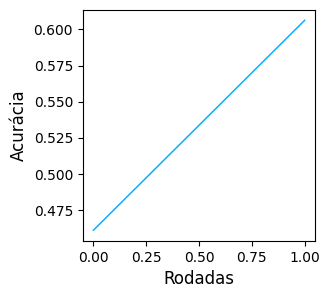

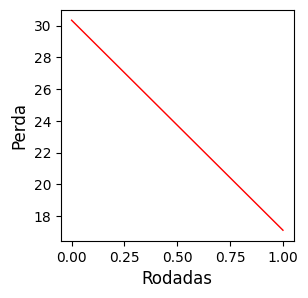

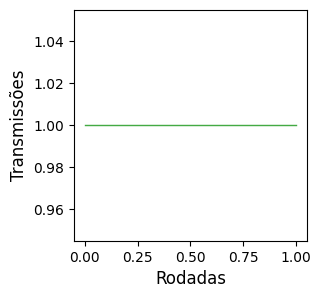

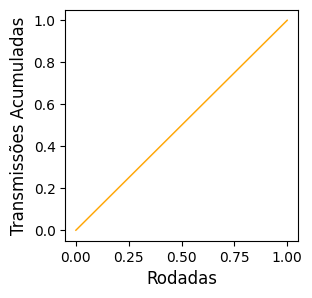

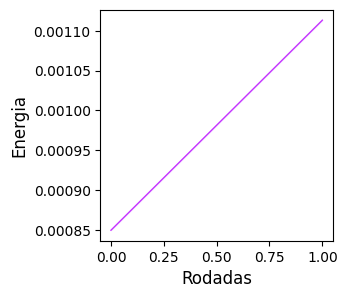

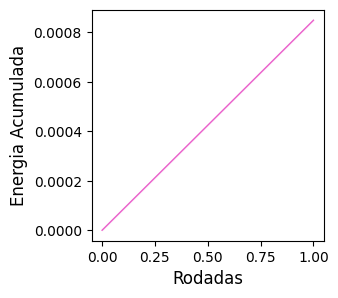

In [114]:
plotar_graficos(save_figure=SAVE_FIGURES, path="graficos/transmissao_condicional/epsilon_55/")